# Train on Movie Data with trained model on Flight 


### Training of DQN in Tensorflow
--------------------------

In [34]:
#
from util import *
from dlg_manager import *
from alg import *
from agent import *
from user_sim import *
from state_tracker import *
import random
from config import *
import matplotlib.pyplot as plt
import numpy as np
from nlg import *
from six.moves import cPickle as pickle
import IPython
import copy, argparse, json

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data
-------------------

#### Action Set

In [2]:
#
act_set_path = './data/dia_acts.txt'
act_set = text_to_dict(act_set_path)
sample_dict(act_set)

keys = 11
Sample of dict:
- not_sure: 10
- request: 0
- inform: 1
- closing: 5
- deny: 9


### slot set

In [3]:
#
slots_set_path = "./data/slot_set.txt"
slot_set = text_to_dict(slots_set_path)
sample_dict(slot_set)

keys = 29
Sample of dict:
- price: 18
- ticket: 27
- city: 2
- starttime: 20
- numberofkids: 15


### movie dic: info about movie

In [4]:
#
movie_kb_path = "./data/movie_kb.1k.p"
movie_kb = pickle.load(open(movie_kb_path, 'rb'), encoding="latin")
sample_dict(movie_kb, sample_size=1)

keys = 991
Sample of dict:
- 426: {'distanceconstraints': 'near', 'date': 'tonight', 'theater': 'amc loews cascade mall', 'zip': '98272', 'city': 'monroe', 'starttime': '9:10', 'moviename': 'kung fu panda 3', 'state': 'wa'}


# Language Generator (pretrained)
-------------------

In [5]:
#
nlg_model_path = './data/trained_model/nlg/lstm_tanh_relu_[1468202263.38]_2_0.610.p'
nlg_model = Nlg()
nlg_model.load_nlg_model(nlg_model_path)
diaact_nl_pairs_path = "./data/nlg/dia_act_nl_pairs.v6.json"
nlg_model.load_predefine_act_nl_pairs(diaact_nl_pairs_path)

## Model Params

In [6]:
#
model_params = pickle.load(open(nlg_model_path, 'rb'), encoding='latin1')
params = model_params['params']
params['batch_size'] = 16
batch_size = 16
save_check_point = 20
params['trained_model_path'] = None
for k in params:
    print("{}: {}".format(k, params[k]))

check_point: 20
split_method: 1
pretrained_model_path: None
activation_func: relu
learning_rate: 0.001
hidden_size: 100
trained_model_path: None
data_path: .\data\movieMultiLine.Annot.Corrected.Final.v3.csv
max_epochs: 200
smooth_eps: 1e-08
grad_clip: -0.0001
dia_slot_val: 2
sdgtype: rmsprop
eva_metric: 2
slot_set: data/slot_set.txt
reg_cost: 0.001
save_check_point: 20
slot_rep: 1
decay_rate: 0.999
batch_size: 16
cv_fold: 6
momentum: 0.1
write_model_dir: .\checkpoints\template\07102016\
feed_recurrence: 0
valid_test: 0
model: lstm_tanh
act_set: data/dia_acts.txt
init_rnn: 0


# User Simulator
-------------------

### goal

In [7]:
#
goal_file_path = './data/user_goals_first_turn_template.part.movie.v1.p'
all_goal_set = pickle.load(open(goal_file_path, 'rb'), encoding="latin")
print("goals length: {}".format(len(all_goal_set)))
print("Sample the first goal: \n{}".format(all_goal_set[0]))

goals length: 128
Sample the first goal: 
{'inform_slots': {'date': 'today', 'theater': 'carmike summit 16', 'starttime': 'around 2pm', 'city': 'birmingham', 'numberofpeople': '1', 'moviename': 'zootopia', 'state': 'al'}, 'request_slots': {}, 'diaact': 'request'}


### Split goal set

In [8]:
# split goal set
split_fold = params.get('split_fold', 5)
goal_set = {'train':[], 'valid':[], 'test':[], 'all':[]}
for u_goal_id, u_goal in enumerate(all_goal_set):
    if u_goal_id % split_fold == 1: goal_set['test'].append(u_goal)
    else: goal_set['train'].append(u_goal)
    goal_set['all'].append(u_goal)
print(len(goal_set['train']))
print(len(goal_set['valid']))
print(len(goal_set['test']))
print(len(goal_set['all']))

102
0
26
128


### user simulator param

In [9]:
#
usersim_params = {}
usersim_params['max_turn'] = 40
usersim_params['slot_err_prob'] = 0.00
# slot_err_mode: 0 for slot_val only; 1 for three errs
usersim_params['slot_err_mode'] = 0
usersim_params['intent_err_prob'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
usersim_params['run_mode'] = 0
# 0 for dia_act level; 1 for NL level
usersim_params['act_level'] = 0
# train/test/all; default is all
usersim_params['learn_phase'] = 'all'

### a movie dictionary for user simulator - slot:possible values

In [10]:
#
movie_dict_path = './data/user/dicts.v3.p'
movie_dictionary = pickle.load(open(movie_dict_path, 'rb'), encoding="latin")
samples = sample_dict(movie_dictionary, sample_size=1)

keys = 20
Sample of dict:
- numberofkids: ['two', '2', '1', 'no']


###  Create a User

In [11]:
user = RuleSimulator(movie_dictionary, act_set, slot_set, goal_set, usersim_params)
user.set_nlg_model(nlg_model)

# Agent
-------------------

## param

In [12]:
#
agent_params = {}
# maximum length of each dialog (default=20, 0=no maximum length)
agent_params['max_turn'] = 40
# Epsilon to determine stochasticity of epsilon-greedy agent policies
agent_params['epsilon'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
agent_params['agent_run_mode'] = 3
# 0 for dia_act level; 1 for NL level
agent_params['agent_act_level'] = 0

############### DQN #################
# the size for experience replay
agent_params['experience_replay_pool_size'] = 10000
# # the hidden size for DQN
agent_params['dqn_hidden_size'] = 60
agent_params['batch_size'] = 16
# # gamma for DQN
agent_params['gamma'] = 0.9
# # predict model for DQN
agent_params['predict_mode'] = True
agent_params['trained_model_path'] = params['pretrained_model_path']
#####################################
print("pretrained model path = {}".format(agent_params['trained_model_path']))
# 0: no warm start; 1: warm start for training
agent_params['warm_start'] = 1
# run_mode: 0 for NL; 1 for dia_act
agent_params['cmd_input_mode'] = 0

success_rate_threshold = 0.3

pretrained model path = None


### create an agent

In [13]:
# agent = RequestBasicsAgent(movie_kb, act_set, slot_set, agent_params)
# agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
# agt = 9
agt = 10
agent_params['batch_size']  = batch_size
if agt == 9:
    agent = AgentDQN(movie_kb,batch_size, act_set, slot_set, agent_params)
else:
    agent = DQNAgentTF(movie_kb, act_set, slot_set, agent_params, transfer=True, path="trained_model/flight_200/model.ckpt")

agent.set_nlg_model(nlg_model)

act_cardinality  11
feasible_actions 43
80
INFO:tensorflow:Restoring parameters from trained_model/flight_200/model.ckpt


# Dialog Manager
-------------------

In [14]:
dlg_manager = DlgManager(agent, user, act_set, slot_set, movie_kb)

## Running Episodes
-------------------

### Param

In [15]:
#
status = {'successes': 0, 'count': 0, 'cumulative_reward': 0}
# the size of validation set
simulation_epoch_size = 100
# the number of epochs for warm start 
warm_start_epochs = 20
# num_episodes = 60

In [16]:
""" Warm_Start Simulation (by Rule Policy) """
def warm_start_simulation():
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(warm_start_epochs):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("warm_start simulation episode %s: Success" % (episode))
#                 else: print ("warm_start simulation episode curve%s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        if len(agent.experience_replay_pool) >= agent.experience_replay_pool_size:
            break
    
    agent.warm_start = 2
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print ("Warm_Start %s epochs, success rate %s, ave reward %s, ave turns %s" % (episode+1, res['success_rate'], res['ave_reward'], res['ave_turns']))
    print ("Current experience replay buffer size %s" % (len(agent.experience_replay_pool)))

In [17]:
def simulation_epoch(simulation_epoch_size):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(simulation_epoch_size):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("simulation episode %s: Success" % (episode))
#                 else: print ("simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
    
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print("simulation success rate %s, ave reward %s, ave turns %s" % (res['success_rate'], res['ave_reward'], res['ave_turns']))
    return res

In [18]:
def run_episodes(count, status):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    
    if agt >= 9 and params['trained_model_path'] == None and agent.warm_start == 1:
        print ('warm_start starting ...')
        warm_start_simulation()
        print ('warm_start finished, start RL training ...')
    
    for episode in range(count):
        print ("----------------- Episode: %s ----------------- " % (episode))
        dlg_manager.init_episode()
        episode_over = False
        
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
                
            if episode_over:
                if reward > 0:
                    print ("Successful Dialog!")
                    successes += 1
#                 else: print ("Failed Dialog!")
                
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        # simulation
        if agt >= 9 and params['trained_model_path'] == None:
            agent.predict_mode = True
            simulation_res = simulation_epoch(simulation_epoch_size)
            
            performance_records['success_rate'][episode] = simulation_res['success_rate']
            performance_records['ave_turns'][episode] = simulation_res['ave_turns']
            performance_records['ave_reward'][episode] = simulation_res['ave_reward']
            
            if simulation_res['success_rate'] >= best_res['success_rate']:
                if simulation_res['success_rate'] >= success_rate_threshold: # threshold = 0.30
                    agent.experience_replay_pool = [] 
                    simulation_epoch(simulation_epoch_size)
                
#             if simulation_res['success_rate'] > best_res['success_rate']:
#                 best_model['model'] = copy.deepcopy(agent)
#                 best_res['success_rate'] = simulation_res['success_rate']
#                 best_res['ave_reward'] = simulation_res['ave_reward']
#                 best_res['ave_turns'] = simulation_res['ave_turns']
#                 best_res['epoch'] = episode
                
            loss = agent.train(batch_size, 1)
            if agt == 10: 
                agent.model.update_target_params()
            else: 
                agent.clone_dqn = copy.deepcopy(agent.dqn)
                
            agent.predict_mode = False
            
            print ("Simulation success rate %s, Ave reward %s, Ave turns %s, Best success rate %s" % (performance_records['success_rate'][episode], performance_records['ave_reward'][episode], performance_records['ave_turns'][episode], best_res['success_rate']))
#             if episode % save_check_point == 0 and params['trained_model_path'] == None: # save the model every 10 episodes
#                 save_model(params['write_model_dir'], agt, best_res['success_rate'], best_model['model'], best_res['epoch'], episode)
#                 save_performance_records(params['write_model_dir'], agt, performance_records)
        curve.append(successes/(episode+1))
        losses.append(loss)
        print("Progress: %s / %s, Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (episode+1, count, successes, episode+1, float(cumulative_reward)/(episode+1), float(cumulative_turns)/(episode+1)))
    print("Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (successes, count, float(cumulative_reward)/count, float(cumulative_turns)/count))
    status['successes'] += successes
    status['count'] += count
    
#     if agt == 9 and params['traained_model_path'] == None:
#         save_model(params['write_model_dir'], agt, float(successes)/count, best_model['model'], best_res['epoch'], count)
#         save_performance_records(params['write_model_dir'], agt, performance_records)


## Run a Warm Start

# Train & Eval
-------------------

In [19]:
performance_records = {}
performance_records['success_rate'] = {}
performance_records['ave_turns'] = {}
performance_records['ave_reward'] = {}

best_model = {}
best_res = {'success_rate': 0, 'ave_reward':float('-inf'), 'ave_turns': float('inf'), 'epoch':0}

curve = []
losses = []
agent.warm_start = 1
run_episodes(200, status)

warm_start starting ...
Warm_Start 20 epochs, success rate 0.11, ave reward 3.8, ave turns 3.2
Current experience replay buffer size 160
warm_start finished, start RL training ...
----------------- Episode: 0 ----------------- 
simulation success rate 0.0, ave reward -60.0, ave turns 42.0
Train on : 2281
- cur bellman err 7.4695, experience replay pool 2281
Simulation success rate 0.0, Ave reward -60.0, Ave turns 42.0, Best success rate 0
Progress: 1 / 200, Success rate: 0 / 1 Avg reward: -60.00 Avg turns: 42.00
----------------- Episode: 1 ----------------- 
simulation success rate 0.0, ave reward -40.0, ave turns 2.0
Train on : 2381
- cur bellman err 10.4237, experience replay pool 2381
Simulation success rate 0.0, Ave reward -40.0, Ave turns 2.0, Best success rate 0
Progress: 2 / 200, Success rate: 0 / 2 Avg reward: -50.00 Avg turns: 22.00
----------------- Episode: 2 ----------------- 
simulation success rate 0.0, ave reward -59.43, ave turns 40.86
Train on : 4424
- cur bellman err

- cur bellman err 0.2313, experience replay pool 46014
Simulation success rate 0.12, Ave reward -43.71, Ave turns 38.22, Best success rate 0
Progress: 24 / 200, Success rate: 0 / 24 Avg reward: -58.42 Avg turns: 38.83
----------------- Episode: 24 ----------------- 
Successful Dialog!
simulation success rate 0.1, ave reward -46.53, ave turns 39.06
Train on : 47967
- cur bellman err 0.8199, experience replay pool 47967
Simulation success rate 0.1, Ave reward -46.53, Ave turns 39.06, Best success rate 0
Progress: 25 / 200, Success rate: 1 / 25 Avg reward: -53.08 Avg turns: 37.76
----------------- Episode: 25 ----------------- 
simulation success rate 0.13, ave reward -38.97, ave turns 31.14
Train on : 49524
- cur bellman err 0.5659, experience replay pool 49524
Simulation success rate 0.13, Ave reward -38.97, Ave turns 31.14, Best success rate 0
Progress: 26 / 200, Success rate: 1 / 26 Avg reward: -53.35 Avg turns: 37.92
----------------- Episode: 26 ----------------- 
simulation success

simulation success rate 0.48, ave reward 4.68, ave turns 27.84
simulation success rate 0.49, ave reward 6.06, ave turns 27.48
Train on : 1374
- cur bellman err 2.3167, experience replay pool 1374
Simulation success rate 0.48, Ave reward 4.68, Ave turns 27.84, Best success rate 0
Progress: 45 / 200, Success rate: 6 / 45 Avg reward: -41.13 Avg turns: 36.27
----------------- Episode: 45 ----------------- 
Successful Dialog!
simulation success rate 0.46, ave reward 2.19, ave turns 28.02
simulation success rate 0.48, ave reward 5.41, ave turns 26.38
Train on : 1319
- cur bellman err 2.5986, experience replay pool 1319
Simulation success rate 0.46, Ave reward 2.19, Ave turns 28.02, Best success rate 0
Progress: 46 / 200, Success rate: 7 / 46 Avg reward: -38.63 Avg turns: 35.78
----------------- Episode: 46 ----------------- 
simulation success rate 0.5, ave reward 8.28, ave turns 25.44
simulation success rate 0.45, ave reward 1.6, ave turns 26.8
Train on : 1340
- cur bellman err 3.7800, expe

simulation success rate 0.6, ave reward 21.78, ave turns 22.44
simulation success rate 0.69, ave reward 33.65, ave turns 20.3
Train on : 1015
- cur bellman err 5.1048, experience replay pool 1015
Simulation success rate 0.6, Ave reward 21.78, Ave turns 22.44, Best success rate 0
Progress: 65 / 200, Success rate: 16 / 65 Avg reward: -26.06 Avg turns: 33.20
----------------- Episode: 65 ----------------- 
Successful Dialog!
simulation success rate 0.68, ave reward 33.13, ave turns 18.94
simulation success rate 0.62, ave reward 25.6, ave turns 19.6
Train on : 980
- cur bellman err 9.0133, experience replay pool 980
Simulation success rate 0.68, Ave reward 33.13, Ave turns 18.94, Best success rate 0
Progress: 66 / 200, Success rate: 17 / 66 Avg reward: -24.52 Avg turns: 32.85
----------------- Episode: 66 ----------------- 
simulation success rate 0.54, ave reward 15.11, ave turns 21.38
simulation success rate 0.53, ave reward 12.53, ave turns 24.14
Train on : 1207
- cur bellman err 3.5314

simulation success rate 0.59, ave reward 20.36, ave turns 22.88
simulation success rate 0.65, ave reward 28.95, ave turns 20.1
Train on : 1005
- cur bellman err 5.2794, experience replay pool 1005
Simulation success rate 0.59, Ave reward 20.36, Ave turns 22.88, Best success rate 0
Progress: 85 / 200, Success rate: 28 / 85 Avg reward: -14.71 Avg turns: 30.47
----------------- Episode: 85 ----------------- 
Successful Dialog!
simulation success rate 0.59, ave reward 19.77, ave turns 24.06
simulation success rate 0.63, ave reward 25.55, ave turns 22.1
Train on : 1105
- cur bellman err 5.3303, experience replay pool 1105
Simulation success rate 0.59, Ave reward 19.77, Ave turns 24.06, Best success rate 0
Progress: 86 / 200, Success rate: 29 / 86 Avg reward: -13.70 Avg turns: 30.33
----------------- Episode: 86 ----------------- 
simulation success rate 0.55, ave reward 15.19, ave turns 23.62
simulation success rate 0.57, ave reward 17.6, ave turns 23.6
Train on : 1180
- cur bellman err 2.7

simulation success rate 0.65, ave reward 28.72, ave turns 20.56
simulation success rate 0.64, ave reward 26.89, ave turns 21.82
Train on : 1091
- cur bellman err 4.9020, experience replay pool 1091
Simulation success rate 0.65, Ave reward 28.72, Ave turns 20.56, Best success rate 0
Progress: 105 / 200, Success rate: 43 / 105 Avg reward: -3.70 Avg turns: 27.70
----------------- Episode: 105 ----------------- 
simulation success rate 0.6, ave reward 21.38, ave turns 23.24
simulation success rate 0.7, ave reward 34.6, ave turns 20.8
Train on : 1040
- cur bellman err 3.4410, experience replay pool 1040
Simulation success rate 0.6, Ave reward 21.38, Ave turns 23.24, Best success rate 0
Progress: 106 / 200, Success rate: 43 / 106 Avg reward: -4.24 Avg turns: 27.83
----------------- Episode: 106 ----------------- 
Successful Dialog!
simulation success rate 0.66, ave reward 30.04, ave turns 20.32
simulation success rate 0.57, ave reward 18.29, ave turns 22.22
Train on : 1111
- cur bellman err 

simulation success rate 0.61, ave reward 22.19, ave turns 24.02
simulation success rate 0.66, ave reward 29.32, ave turns 21.76
Train on : 1088
- cur bellman err 3.8231, experience replay pool 1088
Simulation success rate 0.61, Ave reward 22.19, Ave turns 24.02, Best success rate 0
Progress: 125 / 200, Success rate: 53 / 125 Avg reward: -1.79 Avg turns: 27.34
----------------- Episode: 125 ----------------- 
simulation success rate 0.57, ave reward 18.01, ave turns 22.78
simulation success rate 0.65, ave reward 28.52, ave turns 20.96
Train on : 1048
- cur bellman err 5.0906, experience replay pool 1048
Simulation success rate 0.57, Ave reward 18.01, Ave turns 22.78, Best success rate 0
Progress: 126 / 200, Success rate: 53 / 126 Avg reward: -2.25 Avg turns: 27.46
----------------- Episode: 126 ----------------- 
Successful Dialog!
simulation success rate 0.65, ave reward 28.37, ave turns 21.26
simulation success rate 0.68, ave reward 32.86, ave turns 19.48
Train on : 974
- cur bellman 

simulation success rate 0.86, ave reward 56.38, ave turns 15.64
simulation success rate 0.68, ave reward 33.29, ave turns 18.62
Train on : 931
- cur bellman err 5.5047, experience replay pool 931
Simulation success rate 0.86, Ave reward 56.38, Ave turns 15.64, Best success rate 0
Progress: 145 / 200, Success rate: 70 / 145 Avg reward: 6.01 Avg turns: 25.85
----------------- Episode: 145 ----------------- 
Successful Dialog!
simulation success rate 0.86, ave reward 57.09, ave turns 14.22
simulation success rate 0.84, ave reward 54.05, ave turns 15.5
Train on : 775
- cur bellman err 7.3082, experience replay pool 775
Simulation success rate 0.86, Ave reward 57.09, Ave turns 14.22, Best success rate 0
Progress: 146 / 200, Success rate: 71 / 146 Avg reward: 6.47 Avg turns: 25.77
----------------- Episode: 146 ----------------- 
Successful Dialog!
simulation success rate 0.81, ave reward 50.34, ave turns 15.72
simulation success rate 0.83, ave reward 52.39, ave turns 16.42
Train on : 821
- 

simulation success rate 0.85, ave reward 55.92, ave turns 14.16
simulation success rate 0.83, ave reward 53.44, ave turns 14.32
Train on : 716
- cur bellman err 6.2721, experience replay pool 716
Simulation success rate 0.85, Ave reward 55.92, Ave turns 14.16, Best success rate 0
Progress: 165 / 200, Success rate: 90 / 165 Avg reward: 14.33 Avg turns: 24.24
----------------- Episode: 165 ----------------- 
Successful Dialog!
simulation success rate 0.85, ave reward 55.52, ave turns 14.96
simulation success rate 0.87, ave reward 58.26, ave turns 14.28
Train on : 714
- cur bellman err 5.6366, experience replay pool 714
Simulation success rate 0.85, Ave reward 55.52, Ave turns 14.96, Best success rate 0
Progress: 166 / 200, Success rate: 91 / 166 Avg reward: 14.70 Avg turns: 24.17
----------------- Episode: 166 ----------------- 
Successful Dialog!
simulation success rate 0.79, ave reward 47.84, ave turns 15.92
simulation success rate 0.83, ave reward 52.88, ave turns 15.44
Train on : 772

simulation success rate 0.86, ave reward 56.58, ave turns 15.24
simulation success rate 0.8, ave reward 48.53, ave turns 16.94
Train on : 847
- cur bellman err 3.5551, experience replay pool 847
Simulation success rate 0.86, Ave reward 56.58, Ave turns 15.24, Best success rate 0
Progress: 185 / 200, Success rate: 107 / 185 Avg reward: 18.76 Avg turns: 23.30
----------------- Episode: 185 ----------------- 
simulation success rate 0.77, ave reward 45.02, ave turns 16.76
simulation success rate 0.83, ave reward 52.71, ave turns 15.78
Train on : 789
- cur bellman err 3.5324, experience replay pool 789
Simulation success rate 0.77, Ave reward 45.02, Ave turns 16.76, Best success rate 0
Progress: 186 / 200, Success rate: 107 / 186 Avg reward: 18.33 Avg turns: 23.40
----------------- Episode: 186 ----------------- 
Successful Dialog!
simulation success rate 0.78, ave reward 46.25, ave turns 16.7
simulation success rate 0.83, ave reward 53.09, ave turns 15.02
Train on : 751
- cur bellman err 

In [26]:
raw_curve = [0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.041666666666666664,
 0.04,
 0.07692307692307693,
 0.07407407407407407,
 0.10714285714285714,
 0.13793103448275862,
 0.13333333333333333,
 0.12903225806451613,
 0.125,
 0.15151515151515152,
 0.17647058823529413,
 0.17142857142857143,
 0.19444444444444445,
 0.21621621621621623,
 0.21052631578947367,
 0.20512820512820512,
 0.225,
 0.24390243902439024,
 0.2619047619047619,
 0.27906976744186046,
 0.29545454545454547,
 0.3111111111111111,
 0.32608695652173914,
 0.3191489361702128,
 0.3333333333333333,
 0.3469387755102041,
 0.34,
 0.35294117647058826,
 0.34615384615384615,
 0.3584905660377358,
 0.37037037037037035,
 0.36363636363636365,
 0.375,
 0.38596491228070173,
 0.3793103448275862,
 0.3898305084745763,
 0.4,
 0.4098360655737705,
 0.41935483870967744,
 0.4126984126984127,
 0.421875,
 0.4307692307692308,
 0.4393939393939394,
 0.44776119402985076,
 0.45588235294117646,
 0.463768115942029,
 0.4714285714285714,
 0.4788732394366197,
 0.4861111111111111,
 0.4931506849315068,
 0.5,
 0.5066666666666667,
 0.5131578947368421,
 0.5194805194805194,
 0.5256410256410257,
 0.5189873417721519,
 0.525,
 0.5308641975308642,
 0.5365853658536586,
 0.5421686746987951,
 0.5476190476190477,
 0.5529411764705883,
 0.5465116279069767,
 0.5517241379310345,
 0.5568181818181818,
 0.5617977528089888,
 0.5555555555555556,
 0.5604395604395604,
 0.5652173913043478,
 0.5698924731182796,
 0.574468085106383,
 0.5789473684210527,
 0.5729166666666666,
 0.5773195876288659,
 0.5714285714285714,
 0.5757575757575758,
 0.57,
 0.5742574257425742,
 0.5784313725490197,
 0.5825242718446602,
 0.5865384615384616,
 0.5904761904761905,
 0.5943396226415094,
 0.5981308411214953,
 0.6018518518518519,
 0.6055045871559633,
 0.6090909090909091,
 0.6126126126126126,
 0.6160714285714286,
 0.6194690265486725,
 0.6228070175438597,
 0.6260869565217392,
 0.6293103448275862,
 0.6324786324786325,
 0.635593220338983,
 0.6386554621848739,
 0.6416666666666667,
 0.6446280991735537,
 0.639344262295082,
 0.6422764227642277,
 0.6451612903225806,
 0.648,
 0.6507936507936508,
 0.6535433070866141,
 0.65625,
 0.6589147286821705,
 0.6615384615384615,
 0.6641221374045801,
 0.6590909090909091,
 0.6616541353383458,
 0.664179104477612,
 0.6592592592592592,
 0.6617647058823529,
 0.6642335766423357,
 0.6666666666666666,
 0.6618705035971223,
 0.6642857142857143,
 0.6666666666666666,
 0.6690140845070423,
 0.6713286713286714,
 0.6736111111111112,
 0.6758620689655173,
 0.678082191780822,
 0.673469387755102,
 0.6756756756756757,
 0.6778523489932886,
 0.68,
 0.6821192052980133,
 0.6842105263157895,
 0.6797385620915033,
 0.6818181818181818,
 0.6838709677419355,
 0.6858974358974359,
 0.6815286624203821,
 0.6835443037974683,
 0.6855345911949685,
 0.6875,
 0.6894409937888198,
 0.691358024691358,
 0.6871165644171779,
 0.6890243902439024,
 0.6848484848484848,
 0.6867469879518072,
 0.688622754491018,
 0.6904761904761905,
 0.6923076923076923,
 0.6941176470588235,
 0.695906432748538,
 0.6918604651162791,
 0.6936416184971098,
 0.6954022988505747,
 0.6971428571428572,
 0.6931818181818182,
 0.6949152542372882,
 0.6966292134831461,
 0.6983240223463687,
 0.7,
 0.7016574585635359,
 0.7032967032967034,
 0.7049180327868853,
 0.7065217391304348,
 0.7081081081081081,
 0.7096774193548387,
 0.7112299465240641,
 0.7127659574468085,
 0.7142857142857143,
 0.7157894736842105,
 0.7172774869109948,
 0.71875,
 0.7202072538860104,
 0.7216494845360825,
 0.7230769230769231,
 0.7244897959183674,
 0.7208121827411168,
 0.7222222222222222,
 0.7236180904522613,
 0.725]


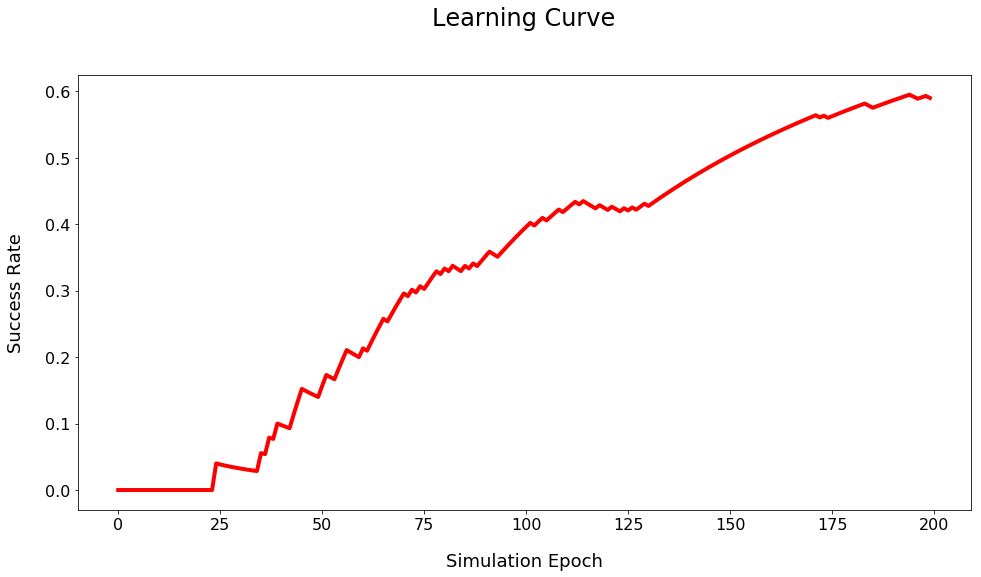

In [27]:
draw_learning_curve(curve)

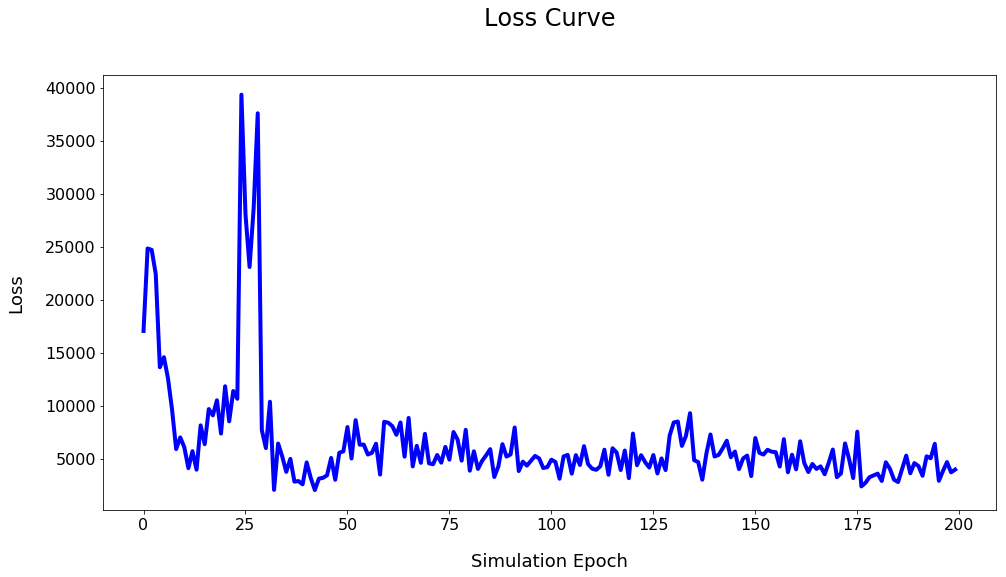

In [28]:
draw_loss_curve(losses)

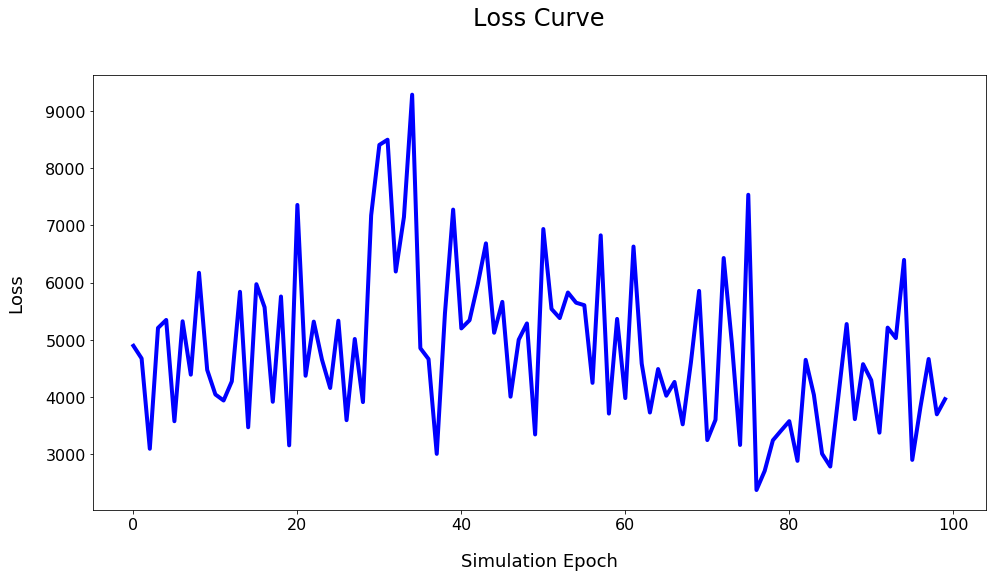

In [29]:
draw_loss_curve(losses[-100:])

In [30]:
saver = tf.train.Saver()

In [31]:
#saver.save(agent.model.sess, "trained_model/tf_400/", global_step = 400)  

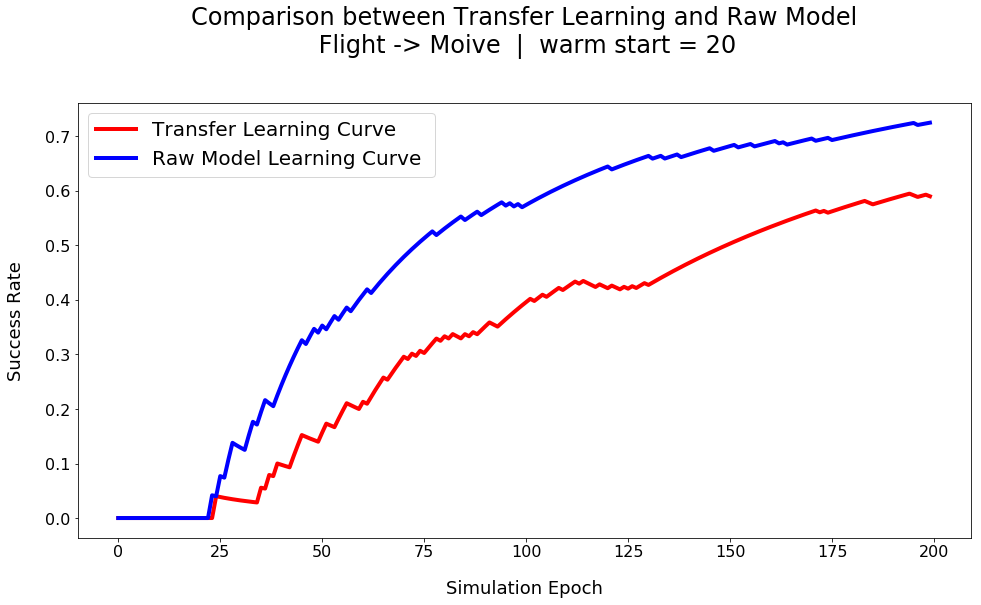

In [40]:
draw_transfer_curve(curve, raw_curve)

In [37]:
raw_curve

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.041666666666666664,
 0.04,
 0.07692307692307693,
 0.07407407407407407,
 0.10714285714285714,
 0.13793103448275862,
 0.13333333333333333,
 0.12903225806451613,
 0.125,
 0.15151515151515152,
 0.17647058823529413,
 0.17142857142857143,
 0.19444444444444445,
 0.21621621621621623,
 0.21052631578947367,
 0.20512820512820512,
 0.225,
 0.24390243902439024,
 0.2619047619047619,
 0.27906976744186046,
 0.29545454545454547,
 0.3111111111111111,
 0.32608695652173914,
 0.3191489361702128,
 0.3333333333333333,
 0.3469387755102041,
 0.34,
 0.35294117647058826,
 0.34615384615384615,
 0.3584905660377358,
 0.37037037037037035,
 0.36363636363636365,
 0.375,
 0.38596491228070173,
 0.3793103448275862,
 0.3898305084745763,
 0.4,
 0.4098360655737705,
 0.41935483870967744,
 0.4126984126984127,
 0.421875,
 0.4307692307692308,
 0.4393939393939394,
 0.44776119402985076,
 0.4